In [1]:
import matplotlib, sys,  os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
sys.path.append("./mylib/")

import numpy as np
matplotlib.use('Agg')
import matplotlib.pyplot as plt

np.seterr(all="ignore")
from threeML import *
from WCDA_hal import HAL, HealpixConeROI, HealpixMapROI
import traceback
silence_warnings()
import warnings
warnings.simplefilter("ignore")
silence_warnings()
from threeML import silence_progress_bars, activate_progress_bars, toggle_progress_bars
from threeML.utils.progress_bar import trange

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
# from astropy.visualization import astropy_mpl_style, imshAow_norm
from astropy.coordinates import Angle

import healpy as hp

from tqdm import tqdm

# from mylib import *
import mylib as my
from importlib import reload

Welcome to JupyROOT 6.24/06


13:49:03 WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=481146;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=472299;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#71\71]8;;\
                  will not be available.                                                                           

/data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


13:49:03 INFO      Starting 3ML!                                                                     ]8;id=79037;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=975923;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=163210;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=37197;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=958705;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=713357;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=162353;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=431145;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#40\40]8;;\

13:49:04 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=503336;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=231382;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=149843;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=273578;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=212118;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=804411;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

13:49:04 WARNING   No fermitools installed                                              ]8;id=617366;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=24816;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

Load sub from Mystat: : 40it [00:00, 66.23it/s]                            

Yourlib init successfully!!!


In [ ]:
# you can do some change about the lib and reload it any time.
reload(my)


WARNING DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



13:49:11 INFO      Creating singleton for                                                            ]8;id=452069;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py\response.py]8;;\:]8;id=397000;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py#41\41]8;;\
                  /data/home/cwy/Science/3MLWCDA/Standard/src/../../data/KM2A1234full_mcpsfnewfix13.               
                  root                                                                                             

13:49:20 INFO      Region of Interest:                                                                   ]8;id=514547;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=844485;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#292\292]8;;\

         INFO      -------------------                                                                   ]8;id=322870;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=118777;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#293\293]8;;\

         INFO      HealpixConeROI: Center (R.A., Dec) = (83.620, 22.010), data radius =      ]8;id=111950;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/region_of_interest/healpix_cone_roi.py\healpix_cone_roi.py]8;;\:]8;id=503311;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/region_of_interest/healpix_cone_roi.py#87\87]8;;\
                  6.000 deg, model radius: 8.000 deg                                                               

         INFO                                                                                            ]8;id=342627;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=602278;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#296\296]8;;\

         INFO      Flat sky projection:                                                                  ]8;id=717260;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=990583;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#297\297]8;;\

         INFO      --------------------                                                                  ]8;id=255377;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=131588;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#298\298]8;;\

         INFO      Width x height 160 x 160 px                                                           ]8;id=690333;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=804223;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#300\300]8;;\

         INFO      Pixel sizes: 0.1 deg                                                                  ]8;id=479953;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=802022;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#305\305]8;;\

         INFO                                                                                            ]8;id=2659;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=93357;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#308\308]8;;\

         INFO      Response:                                                                             ]8;id=370324;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=333534;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#309\309]8;;\

         INFO      ---------                                                                             ]8;id=69299;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=625077;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#310\310]8;;\

         INFO      Response file:                                                                   ]8;id=214204;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py\response.py]8;;\:]8;id=394683;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py#340\340]8;;\
                  /data/home/cwy/Science/3MLWCDA/Standard/src/../../data/KM2A1234full_mcpsfnewfix13                
                  .root                                                                                            

         INFO      Number of dec bins: 110                                                          ]8;id=240612;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py\response.py]8;;\:]8;id=872476;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py#341\341]8;;\

         INFO      Number of energy/nHit planes per dec bin_name: 14                                ]8;id=416248;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py\response.py]8;;\:]8;id=749521;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/response/response.py#344\344]8;;\

         INFO                                                                                            ]8;id=721500;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=117914;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#314\314]8;;\

         INFO      Map Tree:                                                                             ]8;id=427347;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=196309;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#315\315]8;;\

         INFO      ----------                                                                            ]8;id=566974;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=46032;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#316\316]8;;\

,Bin,Nside,Scheme,Obs counts,Bkg counts,obs/bkg,Pixels in ROI,Area (deg^2)
0,0,1024,RING,2.587746e+06,2.576471e+06,1.004376,34469,113.006299
1,1,1024,RING,5.035081e+06,5.004169e+06,1.006177,34469,113.006299
2,2,1024,RING,2.638298e+06,2.608442e+06,1.011446,34469,113.006299
3,3,1024,RING,7.308539e+05,7.136935e+05,1.024045,34469,113.006299
4,4,1024,RING,6.512502e+04,5.924078e+04,1.099328,34469,113.006299
5,5,1024,RING,1.187453e+04,9.472967e+03,1.253517,34469,113.006299
6,6,1024,RING,6.358670e+03,4.921559e+03,1.292003,34469,113.006299
7,7,1024,RING,1.473260e+03,9.970417e+02,1.477631,34469,113.006299
8,8,1024,RING,4.539100e+02,3.054502e+02,1.486036,34469,113.006299
9,9,1024,RING,1.363900e+02,1.055210e+02,1.292539,34469,113.006299


         INFO      This Map Tree contains 884.003 transits in the first bin                         ]8;id=625173;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/maptree/map_tree.py\map_tree.py]8;;\:]8;id=637042;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/maptree/map_tree.py#149\149]8;;\

         INFO      Total data size: 7.72 Mb                                                         ]8;id=927137;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/maptree/map_tree.py\map_tree.py]8;;\:]8;id=932848;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/maptree/map_tree.py#151\151]8;;\

         INFO                                                                                            ]8;id=90645;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=955545;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#320\320]8;;\

         INFO      Active energy/nHit planes (14):                                                       ]8;id=45301;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=260244;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#322\322]8;;\

         INFO      -------------------------------                                                       ]8;id=236507;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=7061;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#323\323]8;;\

         INFO      ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']            ]8;id=599975;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py\HAL.py]8;;\:]8;id=535432;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/HAL.py#324\324]8;;\

Load sub from Mystat: : 40it [00:20, 66.23it/s]Error in <TTreeFormula::Compile>:  Bad numerical expression : "name"


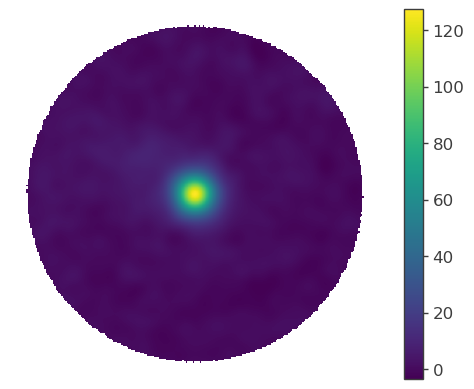

In [2]:
#####   Data Initialize


# maptree = "../../data/KM2A_all_final.root" #old catalog
# response = "../../data/KM2A_DR_all.root"

# maptree = "../../data/KM2A1234full_skymap_rcy.root"
maptree = "../../data/KM2A_20240131_out.root"
# response = "../../data/KM2A1234full_mcpsf_DRfinal.root"
response = "../../data/KM2A1234full_mcpsfnewfix13.root"

region_name="Crab"
if not os.path.exists(f'../res/{region_name}/'):
    os.system(f'mkdir ../res/{region_name}/')
ra, dec =  83.62, 22.01
ra1,dec1=ra, dec

data_radius = 6.0
model_radius = 8.0
roi=HealpixConeROI(ra=ra1,dec=dec1,data_radius=data_radius,model_radius=model_radius)  
KM2A = HAL("KM2A", maptree, response, roi, flat_sky_pixels_size=0.1)

#####   Data Situation
%matplotlib inline
KM2A.set_active_measurements(0, 13)
KM2A.display()

fig = KM2A.display_stacked_image(smoothing_kernel_sigma=0.25) #
fig.show()
fig.savefig(f"../res/{region_name}/counts_all.png",dpi=300)

In [3]:
Modelname="1pt+1gaus+DGE_KM2A"  # Name your model now to facilitate the creation of record folders by the program.
if not os.path.exists(f'../res/{region_name}/{Modelname}/'):
    os.system(f'mkdir ../res/{region_name}/{Modelname}/')

#Without extended parameter settings, it's a point source. When you set the corresponding extension, it becomes the respective source.
# crab = my.setsorce("crab",ra1,dec1, fitrange=1,
#                 indexb=(-10,-1), kb=(1e-14, 1e-8),
#                 )

crab = my.setsorce("crab",ra1,dec1, fitrange=1, alpha= -2.6, beta=0.1, piv=50,
                spec=Log_parabola(), kb=(1e-16, 1e-10)
                )

ext1 = my.setsorce("ext1",85.5, 23.5, sigma=1, fitrange=0.5, sb=(0,3), piv=50, 
                indexb=(-4, -1), kb=(1e-17, 1e-10)
                )

Diffuse = my.set_diffusebkg(
                ra1, dec1, 5, 5,
                piv=50,
                Kb=(1e-17, 1e-10),
                # K = 3.3e-13, index = -2.3,
                Kf=False, indexf=False,
                name="Crab"
                )

lm = Model(crab, ext1, Diffuse) # 

with open(f'../res/{region_name}/{Modelname}/Model_init.txt', 'w') as f:
    for key, value in lm.parameters.items():
        f.write(f'{key}: {value}\n')

lm.display(complete=True)

13:51:32 INFO      Set diffuse range: [179.5547512000012, 189.5547512000012] [-5, 5]                  ]8;id=890772;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=188259;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1234\1234]8;;\

         INFO      ra dec coner:                                                                      ]8;id=229789;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=857352;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1235\1235]8;;\

         INFO      (81.37249761719823, 26.616749974051043)                                            ]8;id=559028;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=603319;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1236\1236]8;;\

         INFO      (87.11456804758984, 18.182579918263535)                                            ]8;id=996017;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=571906;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1237\1237]8;;\

         INFO      (96.45319047987276, 23.049689971887997)                                            ]8;id=381317;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=473584;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1238\1238]8;;\

         INFO      (91.15548575573335, 31.83694343643341)                                             ]8;id=259409;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=254106;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1239\1239]8;;\

         INFO      total sr: 0.03042308573651884                                                      ]8;id=866888;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=634643;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1278\1278]8;;\
                  ratio: 0.011079406267177612                                                                      

         INFO      integration: 2.168245492131819e-06                                                 ]8;id=107760;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=432476;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1279\1279]8;;\
                  ratio: 0.017110833221897825                                                                      

         INFO      set K to: 3.0679013518204547e-13                                                   ]8;id=239108;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=71251;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1280\1280]8;;\

         INFO      diffuse file path: ../../data/Crab_dust_bkg_template.fits                          ]8;id=154480;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py\Myfit.py]8;;\:]8;id=784702;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Myfit.py#1307\1307]8;;\

Model summary:
==============

                  N
Point sources     1
Extended sources  2
Particle sources  0

Free parameters (12):
--------------------

                                       value min_value max_value   
crab.position.ra                       83.62     82.62     84.62  \
crab.position.dec                      22.01     21.01     23.01   
crab.spectrum.main.Log_parabola.K        0.0       0.0       0.0   
crab.spectrum.main.Log_parabola.alpha   -2.6      None      None   
crab.spectrum.main.Log_parabola.beta     0.1      None      None   
ext1.Gaussian_on_sphere.lon0            85.5      85.0      86.0   
ext1.Gaussian_on_sphere.lat0            23.5      23.0      24.0   
ext1.Gaussian_on_sphere.sigma            1.0       0.0       3.0   
ext1.spectrum.main.Powerlaw.K            0.0       0.0       0.0   
ext1.spectrum.main.Powerlaw.index       -2.6      -4.0      -1.0   
Diffuse.spectrum.main.Powerlaw.K         0.0       0.0       0.0   
Diffuse.spectrum.main.Powerlaw.index  -2.733      -4.0      -1.0   

                                                 unit  
crab.position.ra                                  deg  
crab.position.dec                                 deg  
crab.spectrum.main.Log_parabola.K      keV-1 s-1 cm-2  
crab.spectrum.main.Log_parabola.alpha                  
crab.spectrum.main.Log_parabola.beta                   
ext1.Gaussian_on_sphere.lon0                      deg  
ext1.Gaussian_on_sphere.lat0                      deg  
ext1.Gaussian_on_sphere.sigma                     deg  
ext1.spectrum.main.Powerlaw.K          keV-1 s-1 cm-2  
ext1.spectrum.main.Powerlaw.index                      
Diffuse.spectrum.main.Powerlaw.K       keV-1 s-1 cm-2  
Diffuse.spectrum.main.Powerlaw.index                   

Fixed parameters (6):
---------------------

                                                                                 value   
crab.spectrum.main.Log_parabola.piv                                      50000000000.0  \
ext1.spectrum.main.Powerlaw.piv                                          50000000000.0   
Diffuse.SpatialTemplate_2D.K                                                       1.0   
Diffuse.SpatialTemplate_2D.hash      1671117317222293861834942727842365625188929363...   
Diffuse.SpatialTemplate_2D.ihdu                                                    0.0   
Diffuse.spectrum.main.Powerlaw.piv                                       50000000000.0   

                                    min_value max_value   unit  
crab.spectrum.main.Log_parabola.piv      None      None    keV  
ext1.spectrum.main.Powerlaw.piv          None      None    keV  
Diffuse.SpatialTemplate_2D.K             None      None  deg-2  
Diffuse.SpatialTemplate_2D.hash          None      None         
Diffuse.SpatialTemplate_2D.ihdu           0.0      None         
Diffuse.spectrum.main.Powerlaw.piv       None      None    keV  

Properties (2):
--------------------

                                                                       value   
Diffuse.SpatialTemplate_2D.fits_file  ../../data/Crab_dust_bkg_template.fits  \
Diffuse.SpatialTemplate_2D.frame                                        icrs   

                                                            allowed values  
Diffuse.SpatialTemplate_2D.fits_file                                  None  
Diffuse.SpatialTemplate_2D.frame      [icrs, galactic, fk5, fk4, fk4_no_e]  

Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

13:51:41 INFO      Considering 16 dec bins for extended source ext1                 ]8;id=943929;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=19835;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = 23.500                      ]8;id=649555;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=291079;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      Considering 15 dec bins for extended source Diffuse              ]8;id=885891;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=60513;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#93\93]8;;\

         INFO      Central bin is bin at Declination = 24.973                      ]8;id=692986;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py\convolved_extended_source.py]8;;\:]8;id=861376;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/WCDA_hal/convolved_source/convolved_extended_source.py#102\102]8;;\

         INFO      set the minimizer to minuit                                             ]8;id=730382;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=70849;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\

         INFO      set the minimizer to MINUIT                                             ]8;id=343340;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=512605;file:///data/home/cwy/.mylib/miniconda3/envs/3ML/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1059\1059]8;;\

Best fit values:

,result,unit
parameter,,
crab.position.ra,(8.36217 +/- 0.00031) x 10,deg
crab.position.dec,(2.20132 +/- 0.00028) x 10,deg
crab.spectrum.main.Log_parabola.K,(8.58 +/- 0.12) x 10^-25,1 / (keV s cm2)
crab.spectrum.main.Log_parabola.alpha,-3.147 +/- 0.019,
crab.spectrum.main.Log_parabola.beta,(1.64 +/- 0.11) x 10^-1,
ext1.Gaussian_on_sphere.lon0,(8.565 +/- 0.006) x 10,deg
ext1.Gaussian_on_sphere.lat0,(2.311 +/- 0.005) x 10,deg
ext1.Gaussian_on_sphere.sigma,(9.9 +/- 0.6) x 10^-1,deg
ext1.spectrum.main.Powerlaw.K,(2.84 -0.22 +0.24) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00,0.00,0.02,0.00,-0.01,0.08,0.09,-0.07,-0.08,0.02,0.03,0.00
0.00,1.00,0.01,0.01,-0.02,0.07,0.02,-0.03,-0.04,0.01,0.01,0.00
0.02,0.01,1.00,0.38,0.10,0.09,0.09,-0.06,-0.05,-0.02,0.01,-0.00
0.00,0.01,0.38,1.00,-0.81,0.06,0.02,0.07,0.07,-0.00,-0.04,0.02
-0.01,-0.02,0.10,-0.81,1.00,-0.09,-0.05,0.01,0.01,-0.04,-0.01,-0.02
0.08,0.07,0.09,0.06,-0.09,1.00,0.23,0.03,0.06,0.00,-0.16,0.02
0.09,0.02,0.09,0.02,-0.05,0.23,1.00,-0.25,-0.19,0.01,0.02,0.01
-0.07,-0.03,-0.06,0.07,0.01,0.03,-0.25,1.00,0.84,-0.00,-0.53,-0.02
-0.08,-0.04,-0.05,0.07,0.01,0.06,-0.19,0.84,1.00,0.20,-0.64,-0.04
0.02,0.01,-0.02,-0.00,-0.04,0.00,0.01,-0.00,0.20,1.00,-0.01,-0.21
0.03,0.01,0.01,-0.04,-0.01,-0.16,0.02,-0.53,-0.64,-0.01,1.00,0.23


Values of -log(likelihood) at the minimum:

,-log(likelihood)
KM2A,17827.160171
total,17827.160171


Values of statistical measures:

,statistical measures
AIC,35678.320988
BIC,35811.362817


Smoothing planes:   0%|          | 0/14 [00:00<?, ?it/s]

,value,negative_error,positive_error,error,unit
crab.position.ra,8.362173e+01,-3.166486e-03,3.131147e-03,3.148816e-03,deg
crab.position.dec,2.201319e+01,-2.794560e-03,2.888892e-03,2.841726e-03,deg
crab.spectrum.main.Log_parabola.K,8.580874e-25,-1.101829e-26,1.170268e-26,1.136048e-26,1 / (keV s cm2)
crab.spectrum.main.Log_parabola.alpha,-3.147174e+00,-1.840546e-02,1.931363e-02,1.885954e-02,
crab.spectrum.main.Log_parabola.beta,1.641076e-01,-1.117111e-02,1.053341e-02,1.085226e-02,
ext1.Gaussian_on_sphere.lon0,8.564743e+01,-6.114675e-02,6.353078e-02,6.233876e-02,deg
ext1.Gaussian_on_sphere.lat0,2.311400e+01,-4.976877e-02,5.200259e-02,5.088568e-02,deg
ext1.Gaussian_on_sphere.sigma,9.913024e-01,-5.838890e-02,6.114462e-02,5.976676e-02,deg
ext1.spectrum.main.Powerlaw.K,2.843982e-25,-2.114283e-26,2.354097e-26,2.234190e-26,1 / (keV s cm2)
ext1.spectrum.main.Powerlaw.index,-2.903269e+00,-2.770439e-02,2.877293e-02,2.823866e-02,


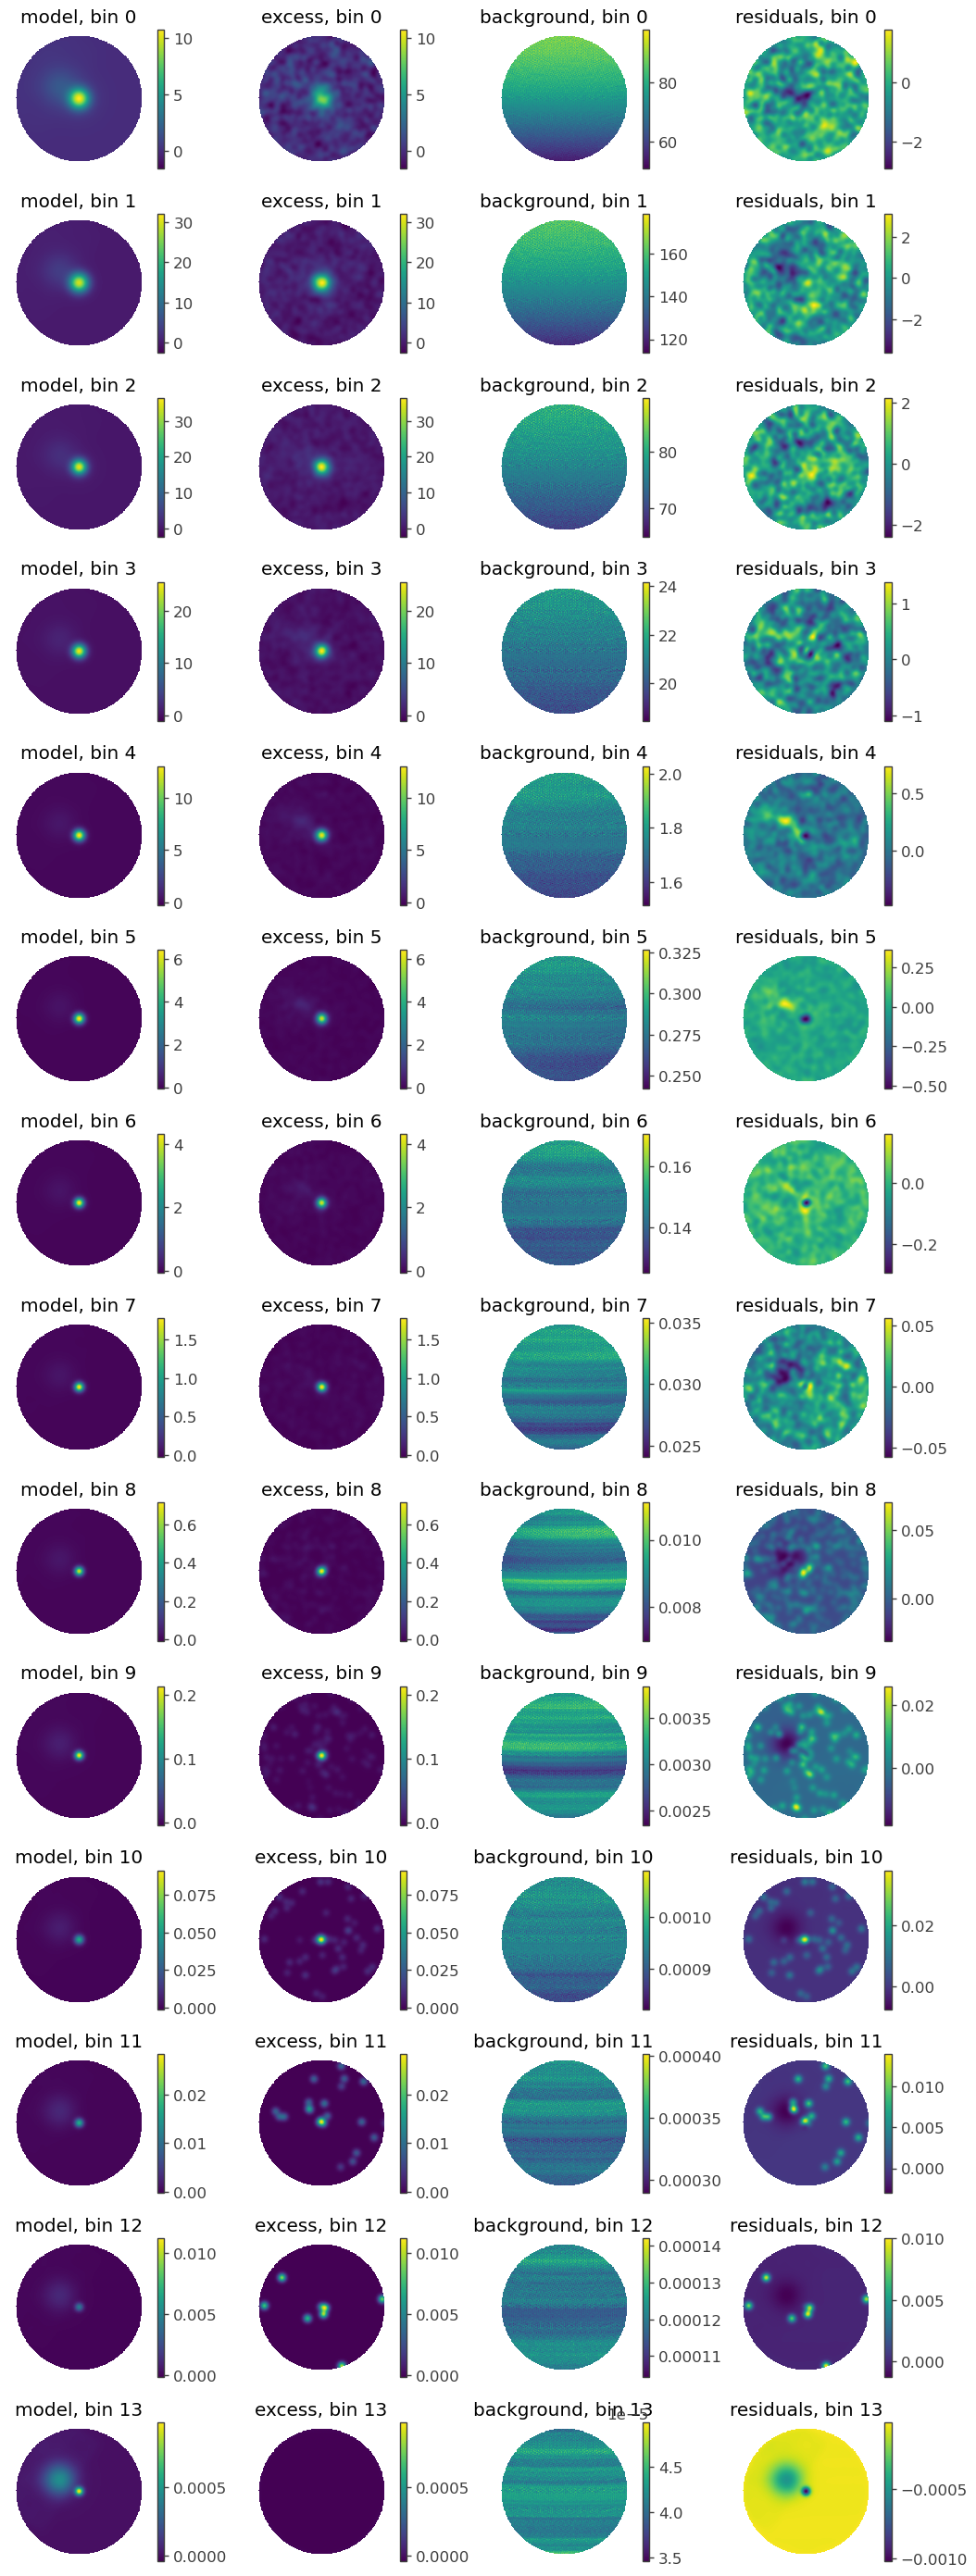

In [4]:
# Attempt the fitting; it will take approximately two minutes.
result = my.fit(region_name, Modelname, KM2A, lm, 0, 13, mini="minuit", ifgeterror=0)
sources = my.get_sources(lm,result)
result[1][0]
# result[0].get_contours(J0248.Gaussian_on_sphere.lon0,39.88,44.88,30)

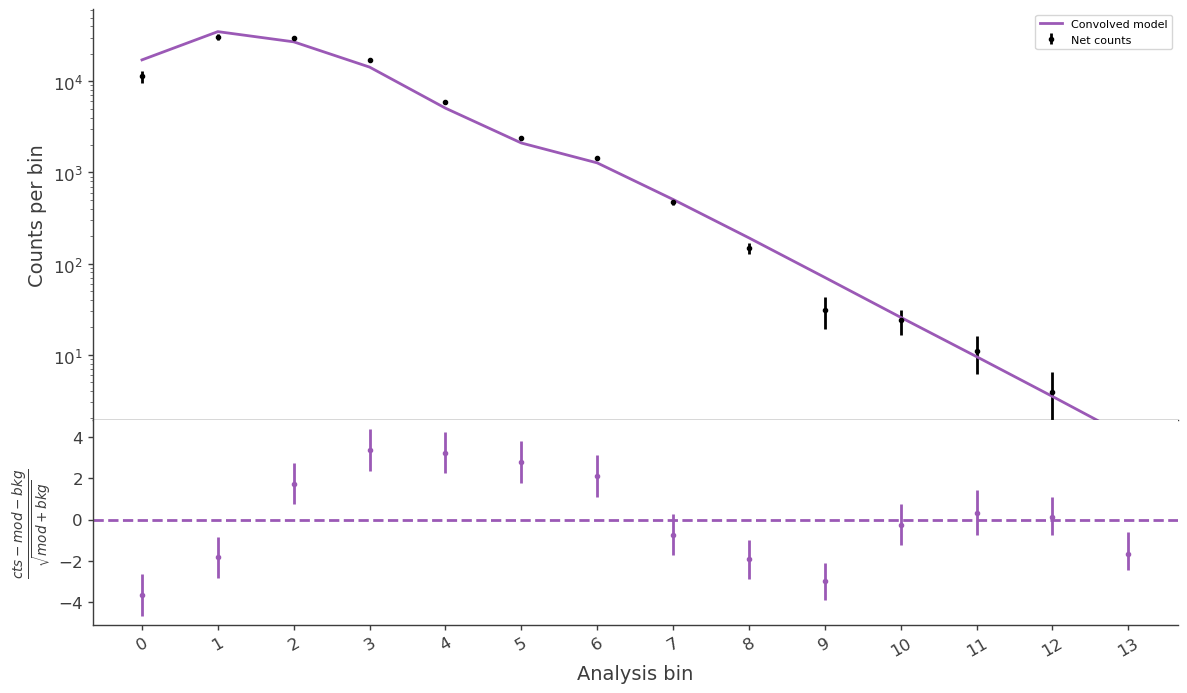

In [5]:
fig = KM2A.display_spectrum()

In [ ]:
# Don't try this!!!! as it requires a significant amount of time!!!"
gof_obj = GoodnessOfFit(result[0])
gof, data_frame, like_data_frame = gof_obj.by_mc(n_iterations=200)

In [ ]:
# Compute Ts,  it will take approximately five minutes.
TSlist = ["crab", "ext1", "Diffuse"]  # A list put the sources that you want to compute TS
TS, TSresults = my.getTSall(TSlist, region_name, Modelname, result, KM2A)
TSresults

11:14:50 INFO      ************************                                                         ]8;id=12109;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py\Mysigmap.py]8;;\:]8;id=727636;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py#600\600]8;;\

         INFO      [4.56081916e+06 4.10763880e-02 1.14617326e+00]                                   ]8;id=33358;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py\Mysigmap.py]8;;\:]8;id=515249;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py#601\601]8;;\

         INFO      ************************                                                         ]8;id=885570;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py\Mysigmap.py]8;;\:]8;id=50131;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py#602\602]8;;\

         INFO      max Significance= 178.8                                                          ]8;id=880924;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py\Mysigmap.py]8;;\:]8;id=577788;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py#603\603]8;;\

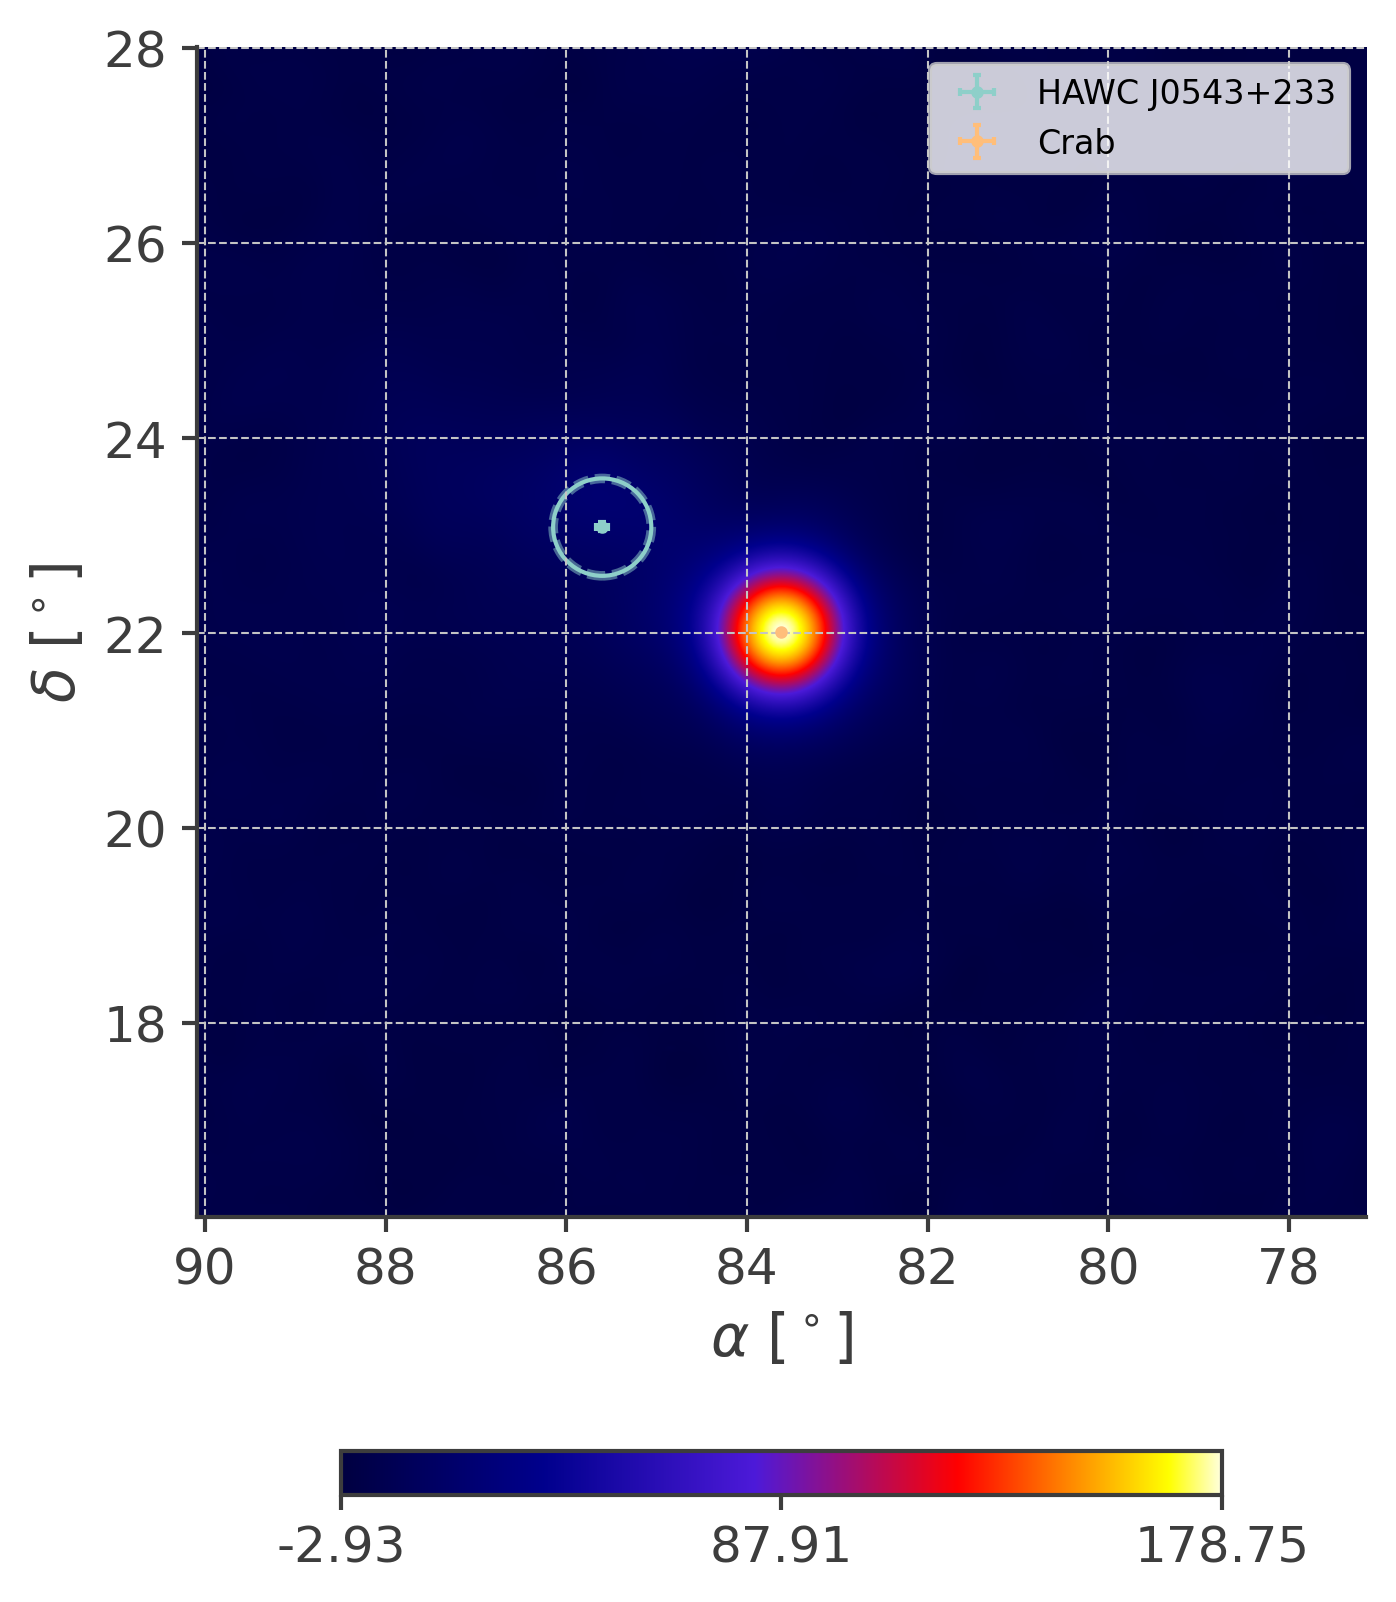

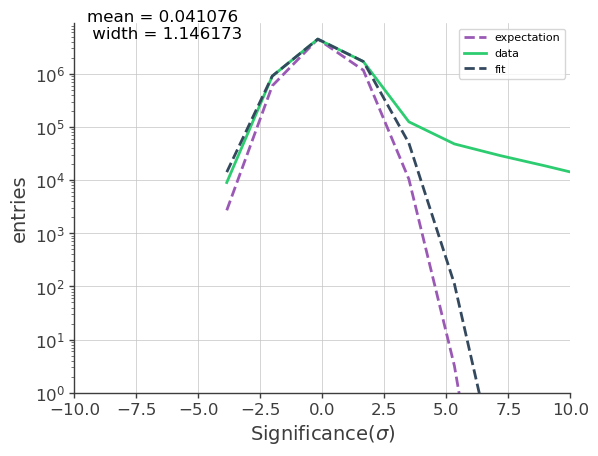

In [11]:
%matplotlib inline
sources = my.get_sources(lm,result)
sources.pop("Diffuse")
sources["HAWC J0543+233"]=sources.pop("ext1")
sources["Crab"]=sources.pop("crab")
# sources={}
map2, skymapHeader = hp.read_map("../../data/fullsky_KM2A_llh-3.5_new.fits.gz",h=True)
map2 = hp.ma(map2)
fig = my.drawmap(region_name, Modelname, sources, map2, ra1, dec1, rad=2*data_radius, contours=[1000],save=True, cat={})
plt.legend()
plt.figure()
my.getsig1D(map2, region_name, Modelname, region_name)



WARNING DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(6.63 -0.32 +0.34) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2110.503699
total,2110.503699


Values of statistical measures:

,statistical measures
AIC,4223.007406
BIC,4234.094271




WARNING DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(8.83 +/- 0.18) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2133.114648
total,2133.114648


Values of statistical measures:

,statistical measures
AIC,4268.229305
BIC,4279.316170




WARNING DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(8.97 +/- 0.14) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2289.612615
total,2289.612615


Values of statistical measures:

,statistical measures
AIC,4581.225238
BIC,4592.312102




WARNING DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(8.48 +/- 0.13) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2296.178554
total,2296.178554


Values of statistical measures:

,statistical measures
AIC,4594.357116
BIC,4605.443980




WARNING DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(8.45 +/- 0.16) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2156.177522
total,2156.177522


Values of statistical measures:

,statistical measures
AIC,4314.355053
BIC,4325.441918




WARNING DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(7.91 +/- 0.23) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,2002.779168
total,2002.779168


Values of statistical measures:

,statistical measures
AIC,4007.558344
BIC,4018.645209




WARNING DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(8.44 -0.31 +0.32) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,1940.441664
total,1940.441664


Values of statistical measures:

,statistical measures
AIC,3882.883336
BIC,3893.970201




WARNING DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(8.8 +/- 0.5) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,1414.483331
total,1414.483331


Values of statistical measures:

,statistical measures
AIC,2830.966671
BIC,2842.053536




WARNING DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(9.8 -0.9 +1.0) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,770.313624
total,770.313624


Values of statistical measures:

,statistical measures
AIC,1542.627256
BIC,1553.714121




WARNING DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(8.8 -1.4 +1.7) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,355.049678
total,355.049678


Values of statistical measures:

,statistical measures
AIC,712.099364
BIC,723.186228




WARNING DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(1.27 -0.30 +0.4) x 10^-24,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,203.267843
total,203.267843


Values of statistical measures:

,statistical measures
AIC,408.535695
BIC,419.622560




WARNING DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(1.3 -0.5 +0.9) x 10^-24,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,107.032011
total,107.032011


Values of statistical measures:

,statistical measures
AIC,216.064029
BIC,227.150894




WARNING DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(1.4 -0.9 +2.5) x 10^-24,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,46.646477
total,46.646477


Values of statistical measures:

,statistical measures
AIC,95.292962
BIC,106.379826




WARNING DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Best fit values:

,result,unit
parameter,,
crab.spectrum.main.Log_parabola.K,(1.0 -0.5 +1.0) x 10^-25,1 / (keV s cm2)


Correlation matrix:

1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
WCDA_1,1.14112
total,1.14112


Values of statistical measures:

,statistical measures
AIC,4.282247
BIC,15.369112


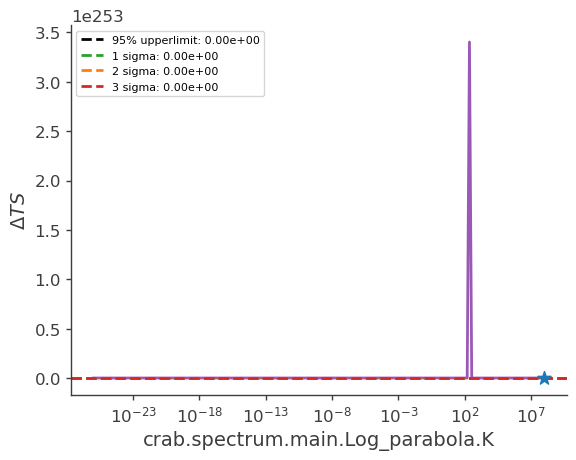


100%|██████████| 14/14 [02:31<00:00, 10.84s/it]


In [6]:
Flux_WCDA, jls1 = my.getdatapoint(KM2A, lm, maptree, response, roi, "crab", piv=50) #, ifpowerlawM=1
# Flux_WCDA2, jls2 = my.getdatapoint(KM2A, lm, maptree, response, roi, "ext1", ifpowerlawM=1, piv=50)
# Flux_WCDA3, jls3 = my.getdatapoint(KM2A, lm, maptree, response, roi, "Diffuse", ifpowerlawM=1, piv=50)

processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/30 [00:00<?, ?it/s]

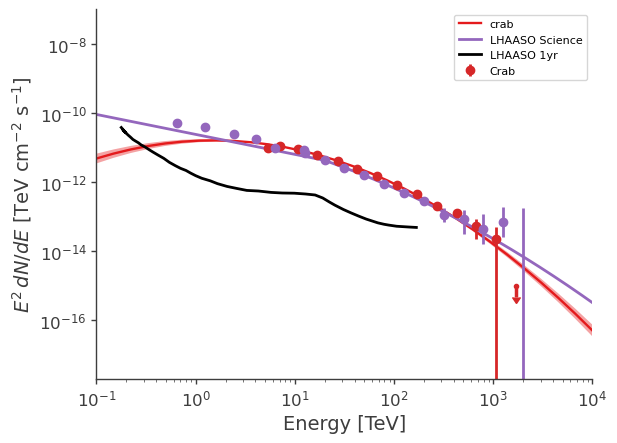

In [7]:
%matplotlib inline
x_Max=10000.
x_Min=.1
y_Min=0.2e-17
y_Max=1e-7
fig,ax = plt.subplots()
plot_spectra(
    result[0].results,
    sources_to_use=["crab"],
    include_extended=True,
    ene_min=x_Min,
    ene_max=x_Max,
    num_ene=30,
    energy_unit="TeV",
    flux_unit="TeV/(s cm2)",
    subplot=ax
    )

my.Draw_sepctrum_points(region_name, Modelname, Flux_WCDA,"Crab","tab:red")
# my.Draw_sepctrum_points(region_name, Modelname, Flux_WCDA3,"ext1","tab:blue")
# my.Draw_sepctrum_points(region_name, Modelname, Flux_WCDA2,"Diffuse","tab:green")

e_J0248=np.linspace(x_Min,x_Max,500)
crab_data = np.array([[0.645589, 4.99911e-11, 5.2533e-12],
[1.23979, 3.89817e-11, 2.24529e-12],
[2.42276, 2.40127e-11, 1.76418e-12],
[4.06902, 1.73829e-11, 1.68635e-12],
[6.35322, 9.85614e-12, 1.47362e-12],
[12.3595, 8.32206e-12, 8.84423e-13]])

crab_data_km2a = np.array([
[12.59, 6.78e-12,  2.90e-13,  2.90e-13],
[19.95, 4.21e-12,  1.76e-13,  1.76e-13],
[31.62, 2.55e-12,  1.16e-13,  1.16e-13],
[50.12, 1.59e-12,  1.00e-13,  1.00e-13],
[79.43, 8.94e-13,  7.54e-14,  7.54e-14],
[125.89, 4.67e-13,  6.46e-14,  6.46e-14],
[199.53, 2.84e-13,  6.04e-14,  6.04e-14],
[316.23, 1.10e-13,  4.12e-14,  6.22e-14],
[501.19, 8.55e-14,  5.42e-14,  6.67e-14],
[794.33, 4.33e-14,  2.74e-14,  7.65e-14],
[1258.93,  6.83e-14 , 4.30e-14 , 1.20e-13],
[1995.26,  -2.12e-16,  0.00e+00,  1.73e-13]])
flux_J0248_sci=e_J0248**2*8.2e-14*pow(e_J0248/10,-2.9-0.19*np.log10(e_J0248/10))
plt.errorbar(crab_data[:,0], crab_data[:,1], crab_data[:,2],fmt="o", c = "tab:purple") #,label='Crab Science'
plt.errorbar(crab_data_km2a[:,0], crab_data_km2a[:,1], [crab_data_km2a[:,2], crab_data_km2a[:,3]],fmt="o", c = "tab:purple") 
plt.plot(e_J0248,flux_J0248_sci,label='LHAASO Science', c = "tab:purple")

LHAASO_sensitivity = np.genfromtxt("../../data/LHAASO_sensitivity.csv",delimiter=',')
plt.plot(LHAASO_sensitivity[:,0],LHAASO_sensitivity[:,1]*1e-11,label="LHAASO 1yr", c="black")

ax.set_xlim(x_Min,x_Max)
ax.set_ylim(y_Min,y_Max)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r"$E^2\,dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Energy [TeV]")
plt.legend()
plt.savefig(f'../res/{region_name}/{Modelname}/Spectrum.png', dpi=300)
plt.savefig(f'../res/{region_name}/{Modelname}/Spectrum.pdf')

In [ ]:
f1 = Flux_WCDA[0][3]*1e9*Flux_WCDA[0][0]**2
e1 = Flux_WCDA[0][0]
f2=Flux_WCDA[0][0]**2*8.2e-14*pow(Flux_WCDA[0][0]/10,-2.9-0.19*np.log10(Flux_WCDA[0][0]/10))
print(e1, f1, f2, (f2-f1)/f2)

In [31]:
# If you want to get residual llh map, you need a new rootfile.
my.write_resmap(region_name, Modelname, KM2A, roi, maptree, response,
ra1, dec1, "crab_res",
[0],[0,0], #point source and ext source, if you have 3pt and 2 ext, and you only want sig about pt1, then use [1,0,0],[0, 0], or you only want 2nd ext: [0,0,0],[0,1]
data_radius,
# binc="all",
binc=["2","3","4","5","6","7","8"],
detector="KM2A"
)
# ! The file you got need use Add_UserInfo.cc in ./tools/llh_skymap to add UserInfo

17:18:49 INFO      crab_res_res                                                                     ]8;id=162107;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py\Mysigmap.py]8;;\:]8;id=180500;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py#679\679]8;;\

         INFO      processing at nHit02                                                             ]8;id=162436;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py\Mysigmap.py]8;;\:]8;id=631305;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py#728\728]8;;\

100%|██████████| 34469/34469 [00:01<00:00, 20815.45it/s]


17:18:52 INFO      processing at nHit03                                                             ]8;id=196888;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py\Mysigmap.py]8;;\:]8;id=419404;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py#728\728]8;;\

100%|██████████| 34469/34469 [00:01<00:00, 20083.05it/s]


17:18:55 INFO      processing at nHit04                                                             ]8;id=518913;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py\Mysigmap.py]8;;\:]8;id=983276;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py#728\728]8;;\

100%|██████████| 34469/34469 [00:01<00:00, 18026.80it/s]


17:18:58 INFO      processing at nHit05                                                             ]8;id=583672;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py\Mysigmap.py]8;;\:]8;id=492277;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py#728\728]8;;\

100%|██████████| 34469/34469 [00:01<00:00, 20692.08it/s]


17:19:00 INFO      processing at nHit06                                                             ]8;id=386518;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py\Mysigmap.py]8;;\:]8;id=255727;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py#728\728]8;;\

100%|██████████| 34469/34469 [00:01<00:00, 18834.84it/s]


17:19:03 INFO      processing at nHit07                                                             ]8;id=136608;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py\Mysigmap.py]8;;\:]8;id=491597;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py#728\728]8;;\

100%|██████████| 34469/34469 [00:01<00:00, 21298.37it/s]


17:19:06 INFO      processing at nHit08                                                             ]8;id=173300;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py\Mysigmap.py]8;;\:]8;id=791538;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py#728\728]8;;\

100%|██████████| 34469/34469 [00:01<00:00, 22266.35it/s]


'crab_res_res'

243754.manage.localdomain
243755.manage.localdomain
243756.manage.localdomain
243757.manage.localdomain
243758.manage.localdomain
243759.manage.localdomain
243760.manage.localdomain
243761.manage.localdomain
243762.manage.localdomain
243763.manage.localdomain
243764.manage.localdomain
243765.manage.localdomain
243766.manage.localdomain
243767.manage.localdomain
243768.manage.localdomain
243769.manage.localdomain
243770.manage.localdomain
243771.manage.localdomain
243772.manage.localdomain
243773.manage.localdomain
243774.manage.localdomain
243775.manage.localdomain
243776.manage.localdomain
243777.manage.localdomain
243778.manage.localdomain
243779.manage.localdomain
243780.manage.localdomain
243781.manage.localdomain
243782.manage.localdomain
243783.manage.localdomain
243784.manage.localdomain
243785.manage.localdomain
243786.manage.localdomain
243787.manage.localdomain
243788.manage.localdomain
243789.manage.localdomain


Error in <TList::Delete>: A list is accessing an object (0x2018f90) already deleted (list name = UserInfo)
Error in <TList::Delete>: A list is accessing an object (0x2098c70) already deleted (list name = UserInfo)
Error in <TList::Delete>: A list is accessing an object (0x20b34f0) already deleted (list name = UserInfo)
Error in <TList::Delete>: A list is accessing an object (0x208d730) already deleted (list name = UserInfo)
Error in <TList::Delete>: A list is accessing an object (0x208d9d0) already deleted (list name = UserInfo)
Error in <TList::Delete>: A list is accessing an object (0x2082890) already deleted (list name = UserInfo)
Error in <TList::Delete>: A list is accessing an object (0x2082b30) already deleted (list name = UserInfo)
Error in <TList::Delete>: A list is accessing an object (0x210e2d0) already deleted (list name = UserInfo)
Error in <TList::Delete>: A list is accessing an object (0x210a050) already deleted (list name = UserInfo)
Error in <TList::Delete>: A list is a

setting the output map dtype to [dtype('float64')]


LHAASO:  1 83.62 22.01 1LHAASO J0534+2200u  0.0
LHAASO:  2 83.61 22.04 1LHAASO J0534+2200u   0.0
LHAASO:  3 85.71 23.2  1LHAASO J0542+2311u  0.98
LHAASO:  4 86.07 23.19  1LHAASO J0542+2311u   1.45
TeVCat:  1 80.43749999999999 21.214277777777777 VER J0521+211 0.0
TeVCat:  2 83.62874999999998 22.01236111111111 Crab 0.0145
TeVCat:  3 83.63291666666665 22.0145 Crab Pulsar 0.0
TeVCat:  4 85.77999999999999 23.4 HAWC J0543+233 0.5
PSR:  1 79.29166666666666 22.266666666666666 J0517+22
PSR:  2 82.21774999999998 22.00111111111111 J0528+2200
PSR:  3 83.63320833333333 22.01447222222222 J0534+2200
PSR:  4 85.79025 23.484722222222224 J0543+2329
PSR:  5 86.61983333333332 24.689166666666665 J0546+2441
SNR:  1 83.62916666666665 22.016666666666666 G184.6-05.8
SNR:  2 84.75 27.833333333333332 G180.0-01.7
3FHL:  1 77.52109 18.008722 3FHL J0510.0+1800
3FHL:  2 80.44172 21.213364 3FHL J0521.7+2112
3FHL:  3 83.634834 22.019203 3FHL J0534.5+2201
3FHL:  4 84.06884 17.566227 3FHL J0536.2+1733
3FHL:  5 84.41 27.

17:42:12 INFO      1201 1200                                                                        ]8;id=902473;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py\Mysigmap.py]8;;\:]8;id=303095;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py#409\409]8;;\

17:42:14 INFO      ************************                                                         ]8;id=488298;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py\Mysigmap.py]8;;\:]8;id=67907;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py#600\600]8;;\

         INFO      [1.10951214e+03 1.79515903e-01 1.14928959e+00]                                   ]8;id=564787;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py\Mysigmap.py]8;;\:]8;id=68910;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py#601\601]8;;\

         INFO      ************************                                                         ]8;id=521549;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py\Mysigmap.py]8;;\:]8;id=323573;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py#602\602]8;;\

         INFO      max Significance= 7.5                                                            ]8;id=553539;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py\Mysigmap.py]8;;\:]8;id=920367;file:///data/home/cwy/Science/3MLWCDA/Standard/src/./mylib/Mysigmap.py#603\603]8;;\

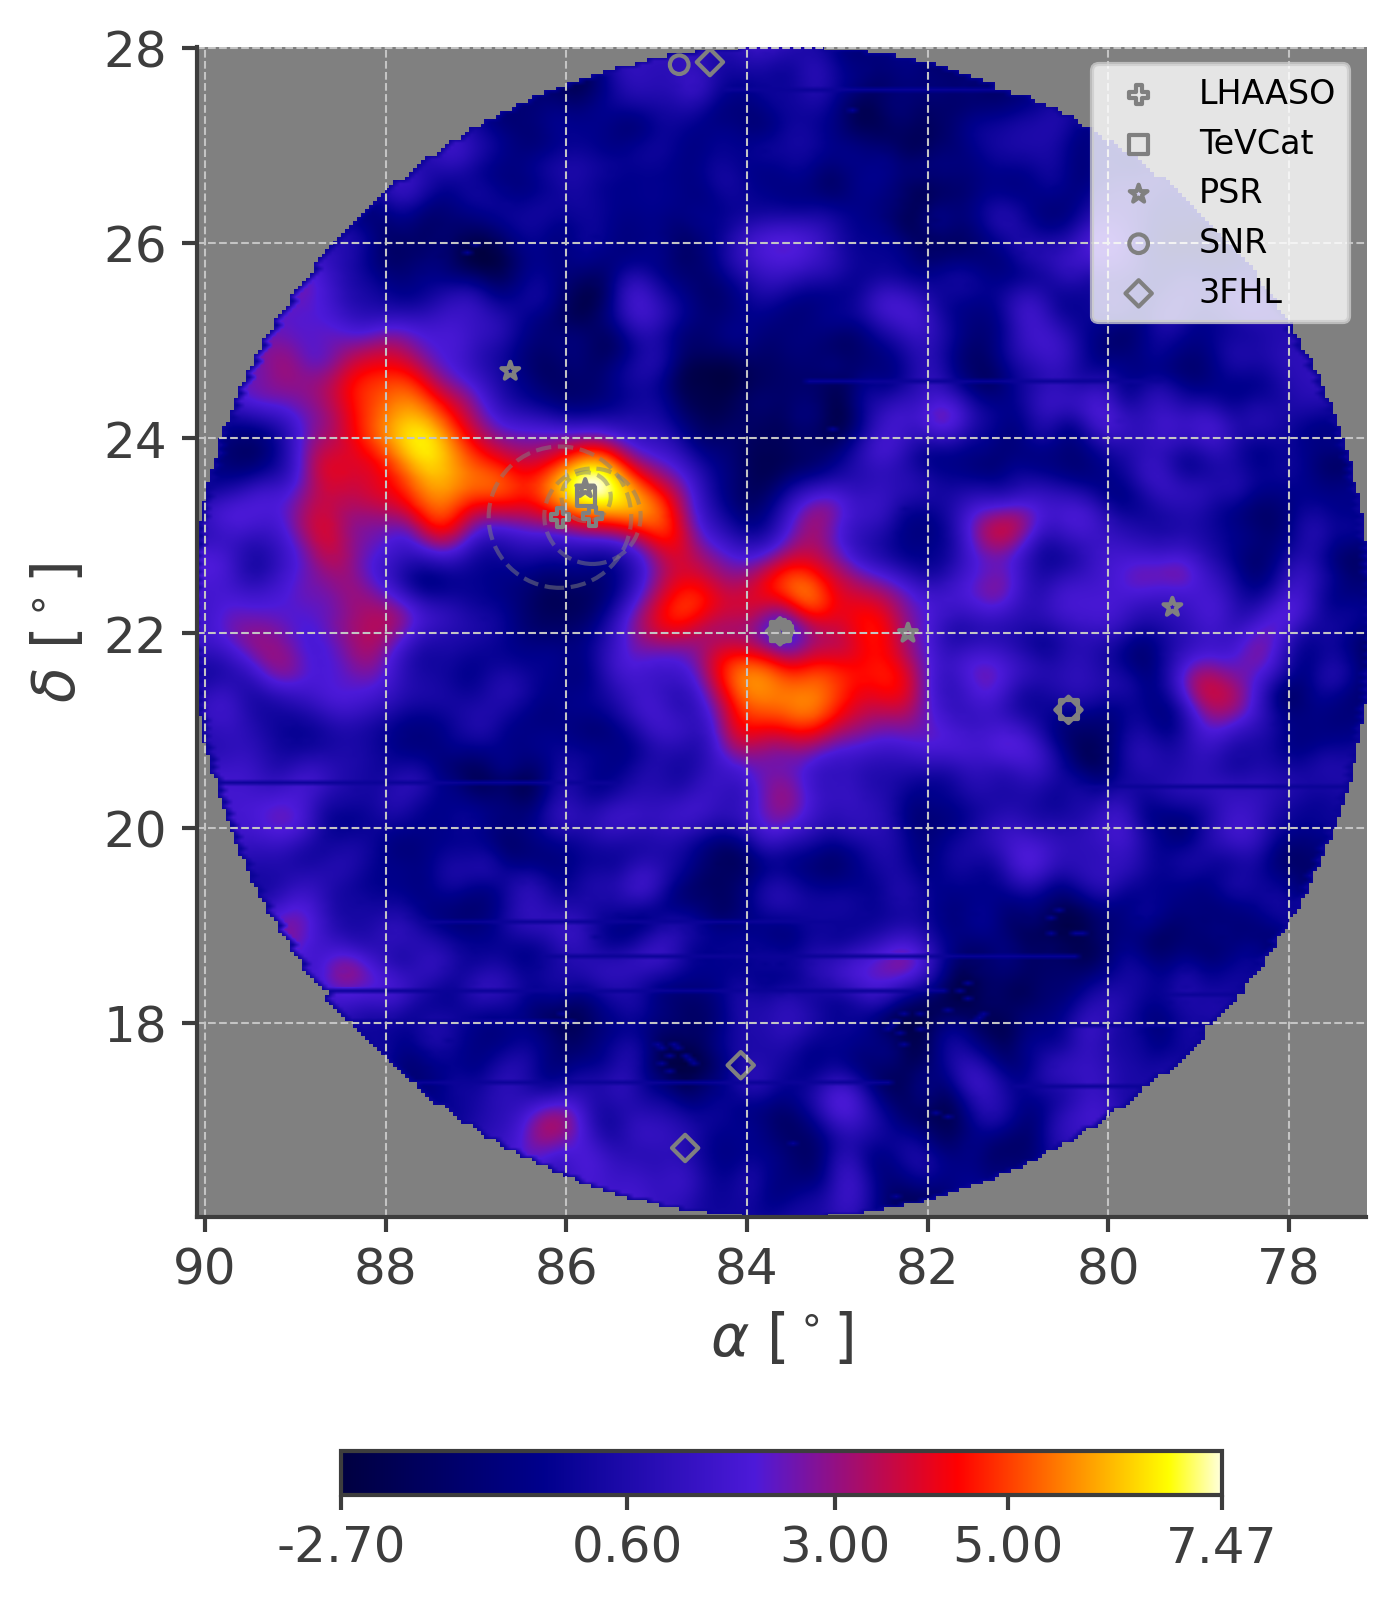

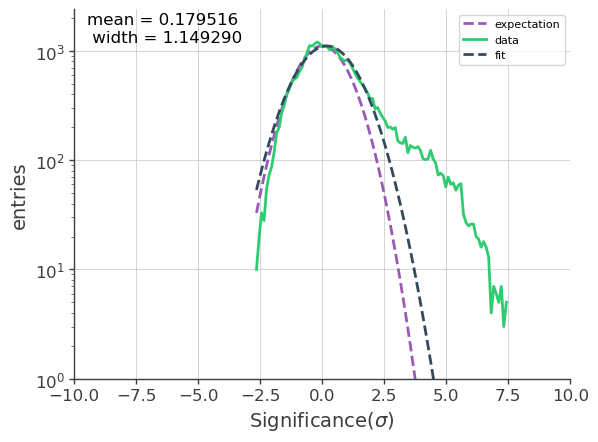

In [32]:
%matplotlib inline
resmap = my.getllhskymap("crab_res_res", region_name, Modelname, ra1, dec1, data_radius, ifsave=True, ifdraw=1, tofits=1, detector="KM2A")
my.getsig1D(resmap, region_name, Modelname, region_name)

In [ ]:
#About 5 min
smoothsigma=[0.4123, 0.3111, 0.2476, 0.2064, 0.1633, 0.1379, 0.2896, 0.2594, 0.2152, 0.189, 0.1561, 0.14]#The first six bins are normal, and the following ones are merged bins, representing the total (merged), without the first bin, and without the first two bins, respectively.
maps = my.getmap(KM2A,roi,"Crab",
                 modelindex=[1,2], # modelindex: pt and ext number
               # pta=[0], exta=[0],
                   stack=[1.010229, 1.020917, 1.040597, 1.064803, 1.090451, 1.130015], #Combine bins with all bin based on signal-to-noise ratio.
                  #  stack=[0, 0, 1.002131,1.005977,1.002093,1.004078], #Combine bins with nhit >= 200 based on signal-to-noise ratio.
                  #  stack=[0, 1.002131,1.005977,1.002093,1.004078],
                   smoothsigma=smoothsigma
                   #, binc=["1","2","3","4","5"]
                   )
smapall = my.smoothmap(maps[-1], smooth_sigma=0.2896)

In [ ]:
%matplotlib inline
psfdata = my.Draw_lateral_distribution(region_name, Modelname, maps[0], 83.622, 22.002, 20, 0.1, True)

In [ ]:
%matplotlib inline
res=True # Do you want resmap? or org map.
saven = "Significance"
if res:
    saven+="_res"
sigmap = my.getsigmap(region_name, Modelname, [smapall],i=0,signif=17,res=res,name="Crab")
fig = my.drawmap(region_name, Modelname, sources, sigmap, ra1, dec1, rad=2*data_radius, contours=[1000],save=True,savename=saven)
#There is another source around crab, so you can try another model: 1pt+1gaus maybe?